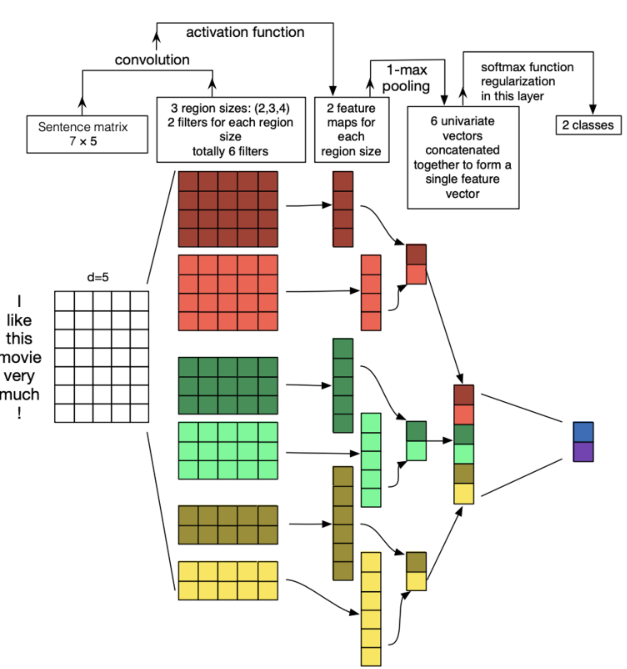

In [ ]:
# !git clone https://github.com/congnghia0609/ntc-scv.git
# !unzip ./ntc-scv/data/data_test.zip -d ./data/ntc-scv
# !unzip ./ntc-scv/data/data_train.zip -d ./data/ntc-scv
# !rm -rf ./ntc -scv

In [19]:
import os
import pandas as pd


def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf -8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)


folder_paths = {
    'train': './data/ntc-svc/data_train/train',
    'valid': './data/ntc-svc/data_train/test',
    'test': './data/ntc-svc/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])


## Preprocessing data

- Delete the comments are not vietnamese

In [22]:
# !pip install langid

from langid.langid import LanguageIdentifier, model
def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model , norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx , row in df.iterrows ():
        score = identifier.classify(row["sentence"])
        if score [0] != "vi" or (score [0] == "vi" and score [1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df , not_vi_df

train_df_vi , train_df_other = identify_vn(train_df)

- Clean the data
  - Delete the HTML tags, URL
  - Delete the punctuation, numbers
  - Delete the special characters, emojis, ...
  - White space normalization
  - Lowercase all the text

In [23]:
import re
import string

def preprocess_text(text):
    url_pattern = re.compile(r'https ?://\s+\wwww \.\s+')
    text = url_pattern.sub(r" ", text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char , " ")

    emoji_pattern = re.compile("["
        u"\U0001F600 -\ U0001F64F" # emoticons
        u"\U0001F300 -\ U0001F5FF" # symbols & pictographs
        u"\U0001F680 -\ U0001F6FF" # transport & map symbols
        u"\U0001F1E0 -\ U0001F1FF" # flags (iOS)
        u"\U0001F1F2 -\ U0001F1F4" # Macau flag
        u"\U0001F1E6 -\ U0001F1FF" # flags
        u"\U0001F600 -\ U0001F64F"
        u"\U00002702 -\ U000027B0"
        u"\U000024C2 -\ U0001F251"
        u"\U0001f926 -\ U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640 -\ u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    return text.lower()

<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:24: SyntaxWarning: invalid escape sequence '\ '
<>:25: SyntaxWarning: invalid escape sequence '\ '
<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:24: SyntaxWarning: invalid e

In [24]:
train_df_vi['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()
]
valid_df['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in valid_df.iterrows()
]
test_df['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in test_df.iterrows()
]


C:\Users\duchu\AppData\Local\Temp\ipykernel_1168\168616711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [


### Text representation as vector

In [16]:
!pip install -q torchtext

In [25]:
# word-based tokenization
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# create iter dataset
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size ,
    specials =["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

# convert iter into torchtext dataset
from torchtext.data.functional import to_map_style_dataset
def prepare_dataset(df):
    for index , row in df.iterrows ():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence , label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

In [26]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    # create inputs , offsets , labels for batch
    encoded_sentences , labels = [], []
    for encoded_sentence , label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence , dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels , dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences ,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences , labels

batch_size = 128
train_dataloader = DataLoader(
    train_dataset ,
    batch_size=batch_size ,
    shuffle=True ,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset ,
    batch_size=batch_size ,
    shuffle=False ,
    collate_fn=collate_batch
)

## Building the TextCNN model

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self,vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        batch_size, sequence_length = x.shape
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x


## Training the model

In [28]:
import time


def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count)
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

# Evaluation
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [32]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss , acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss{:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ". format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss)
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()


| epoch   1 |    50/  233 batches | accuracy    0.736
| epoch   1 |   100/  233 batches | accuracy    0.848
| epoch   1 |   150/  233 batches | accuracy    0.857
| epoch   1 |   200/  233 batches | accuracy    0.871
-----------------------------------------------------------
| End of epoch   1 | Time: 465.82s | Train Accuracy    0.876 | Train Loss   0.382 | Valid Accuracy    0.879 | Valid Loss    0.314 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.921
| epoch   2 |   100/  233 batches | accuracy    0.911
| epoch   2 |   150/  233 batches | accuracy    0.917
| epoch   2 |   200/  233 batches | accuracy    0.912
-----------------------------------------------------------
| End of epoch   2 | Time: 336.36s | Train Accuracy    0.905 | Train Loss   0.232 | Valid Accuracy    0.886 | Valid Loss    0.298 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.951
| epoch   3 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


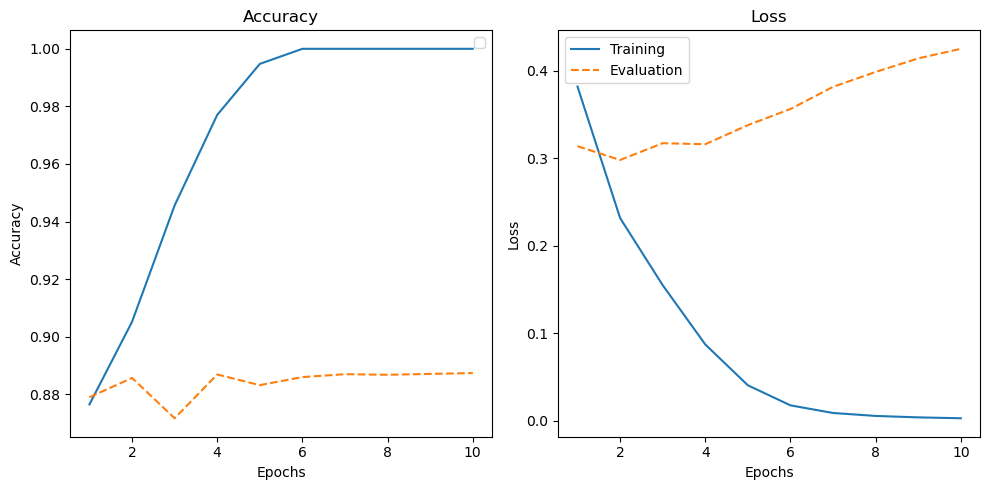

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axes[0].plot(epochs, train_accs, linestyle='-')
axes[0].plot(epochs, eval_accs, linestyle='--')
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Loss
axes[1].plot(epochs, train_losses, label="Training", linestyle='-')
axes[1].plot(epochs, eval_losses, label="Evaluation", linestyle='--')
axes[1].set_title("Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show();

In [36]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

test_dataloader = DataLoader(
    test_dataset ,
    batch_size=batch_size ,
    shuffle=False ,
    collate_fn=collate_batch
)

test_acc , test_loss = evaluate(model , criterion , valid_dataloader)
test_acc , test_loss

(0.8874, 0.42530141761408574)